In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
model_name = "actionvalue_v2_no_freeze"

In [3]:
def load_model_metrics(model_name, drop_first_n = 0, exclude_epochs = tuple()):
    model_df = pd.read_csv(f'{model_name}_epoch_metrics.csv')
    if np.isnan(model_df.loc[0, "epoch"]):
        # set correct epoch for values with no training
        model_df.loc[0, "epoch"] = model_df.loc[1, "epoch"] - 1

    # Filter out excluded epochs
    model_df = model_df.iloc[drop_first_n:]
    if len(exclude_epochs) > 0:
        loss_cols = [c for c in model_df.columns if c.endswith("loss")] 
        model_df.loc[model_df['epoch'].isin(exclude_epochs), loss_cols] = np.nan

    return model_df

In [16]:
# Load metrics
# Add parameters to control which data points to show
drop_first_n = 0
exclude_epochs = []  # List of epoch numbers to exclude from visualization

model_df = load_model_metrics(model_name, drop_first_n, exclude_epochs)

In [5]:
# Display the first few rows to understand the data structure
print("First 5 rows of stateflow data:")
print(model_df.head())

# Check for columns in the dataframe
print("\nColumns in the stateflow dataset:")
print(model_df.columns.tolist())

First 5 rows of stateflow data:
     epoch  train_loss  val_loss  train_time_sec  val_time_sec  total_time_sec
120    119    0.756125  0.696969      405.571784     39.021544      444.593327
121    120    0.755875  0.704202      405.557312     39.776620      445.333932
122    121    0.755025  0.692123      404.175577     39.594207      443.769783
123    122    0.756913  0.697195      402.938831     41.151582      444.090413
124    123    0.763213  0.705538      404.204795     39.395480      443.600276

Columns in the stateflow dataset:
['epoch', 'train_loss', 'val_loss', 'train_time_sec', 'val_time_sec', 'total_time_sec']


In [22]:
def plot_loss(ax0, model_df, name=""):
    # Plot on the first axis (linear scale)
    ax0.plot(model_df['epoch'], model_df['train_loss'], 
            marker='o', label=name + ' Training Loss')
    ax0.plot(model_df['epoch'], model_df['val_loss'], 
            marker='o', label=name + ' Validation Loss')
    ax0.set_title('Loss over Epochs (Linear Scale)')
    ax0.set_xlabel('Epoch')
    ax0.set_ylabel('Loss')
    ax0.legend()
    ax0.grid(True)

In [19]:
old_model_df = load_model_metrics("actionvalue_with_freeze", drop_first_n, exclude_epochs)

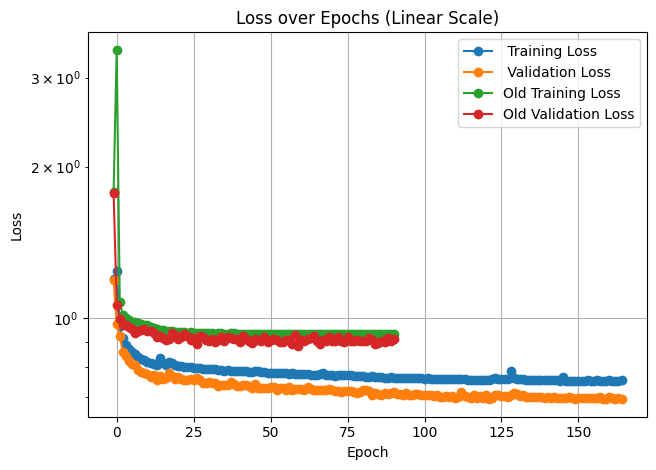

In [ ]:
fig, ax0 = plt.subplots(1, 1)

plot_loss(ax0, model_df)
plot_loss(ax0, old_model_df, "Old")

fig.tight_layout()

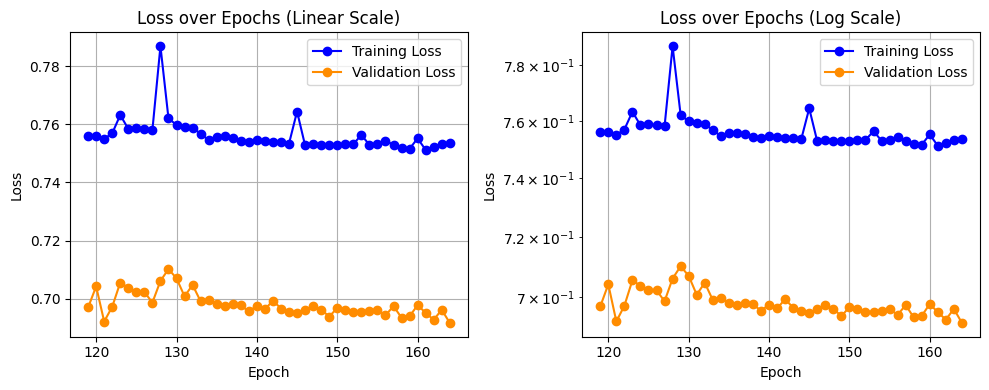

In [7]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4))

# Plot on the first axis (linear scale)
ax0.plot(model_df['epoch'], model_df['train_loss'], 
        marker='o', color='blue', label='Training Loss')
ax0.plot(model_df['epoch'], model_df['val_loss'], 
        marker='o', color='darkorange', label='Validation Loss')
ax0.set_title('Loss over Epochs (Linear Scale)')
ax0.set_xlabel('Epoch')
ax0.set_ylabel('Loss')
ax0.legend()
ax0.grid(True)

# Plot on the second axis (log scale)
ax1.plot(model_df['epoch'], model_df['train_loss'], 
        marker='o', color='blue', label='Training Loss')
ax1.plot(model_df['epoch'], model_df['val_loss'], 
        marker='o', color='darkorange', label='Validation Loss')
ax1.set_title('Loss over Epochs (Log Scale)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)
ax1.set_yscale('log')

fig.tight_layout()
plt.show()

In [8]:
# load latest model

from learning.model.nodevalue import NodeValueModel
from learning.model.actionvalue_v2 import ActionValueModelV2
import torch
import glob
import os


model = ActionValueModelV2()

models_dir = f"learning/{model_name}_checkpoints" 

# Find the latest checkpoint file (with highest epoch number)
checkpoint_files = glob.glob(os.path.join(models_dir, f"{model_name}_*.pt"))
epoch_nums = [int(f.split("_")[-1].split(".")[0]) for f in checkpoint_files]
latest_epoch = max(epoch_nums)
latest_checkpoint = os.path.join(models_dir, f"{model_name}_{latest_epoch:06}.pt")
checkpoint = torch.load(latest_checkpoint, map_location=torch.device('cpu'))
model_state = checkpoint["model_state"]
model.load_state_dict(model_state)

print(f"Loading latest checkpoint: {latest_checkpoint} (epoch {latest_epoch})")

Loading latest checkpoint: learning/actionvalue_v2_no_freeze_checkpoints/actionvalue_v2_no_freeze_000164.pt (epoch 164)


8


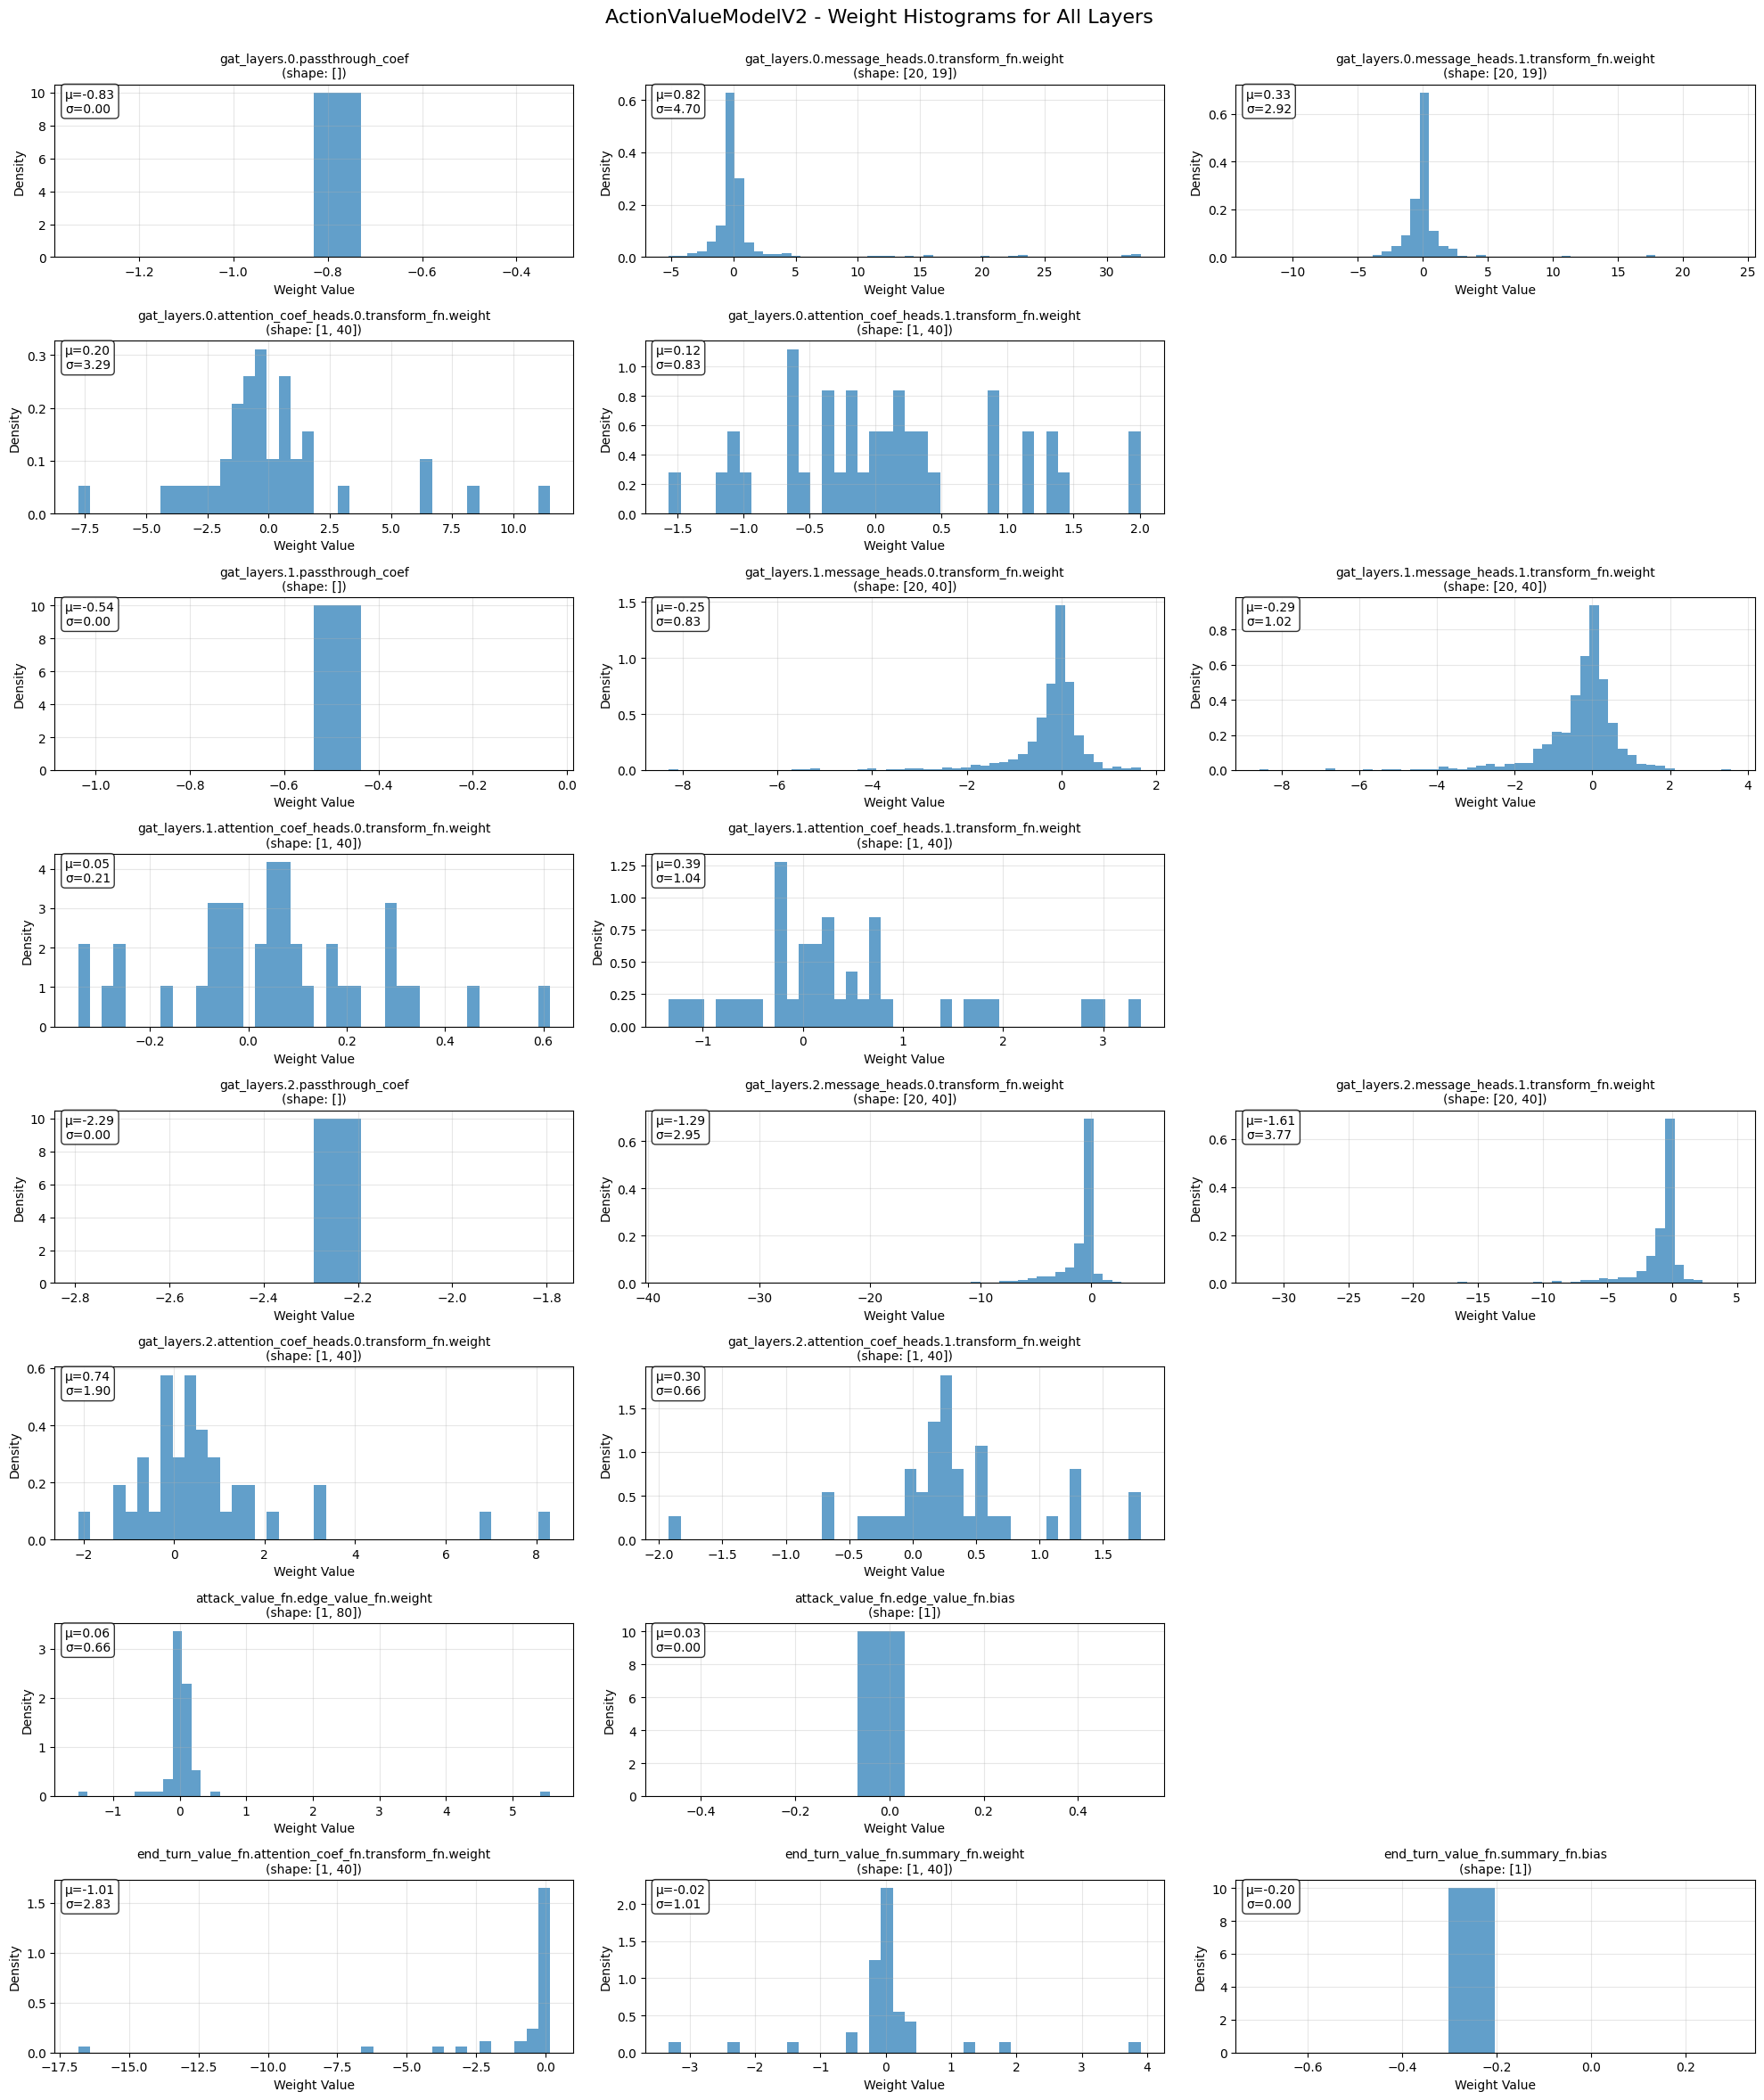

In [9]:
# Weight inspection: Create histograms for each layer
import matplotlib.pyplot as plt
import numpy as np
import re
from collections import defaultdict

def plot_weight_histograms(model, title_prefix=""):
    """Plot histograms of weights for each named parameter in the model"""
    
    # Get all named parameters
    named_params = list([(name, p) for name, p in model.named_parameters() if p.requires_grad])
    
    # Calculate grid dimensions
    n_params = len(named_params)
    n_cols = 3

    param_groups = defaultdict(list)
    for (name, param) in named_params:
        # prefix is either "word" or "word.<number>"
        prefix = re.match(r"^(\w+\.?(?:\d+(?:\.|$))?)", name).group(1)
        param_groups[prefix].append((name, param))

    n_rows = 0
    rows_per_group = []
    for pref, param_l in param_groups.items():
        rows_per_group.append(int(np.ceil(len(param_l) / n_cols)))
        n_rows += rows_per_group[-1]

    print(n_rows)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 3 * n_rows))
    fig.suptitle(f'{title_prefix}Weight Histograms for All Layers', fontsize=16)
    
    axes = axes.ravel()
    

    for group_i, group in enumerate(param_groups.values()):
        group_axes = axes[
            n_cols * sum(rows_per_group[:group_i]) : n_cols * sum(rows_per_group[:(group_i+1)])
        ]
        for i, (name, param) in enumerate(group):
            ax = group_axes[i]
            
            # Convert parameter to numpy and flatten
            weights = param.detach().cpu().numpy().flatten()
            
            # Create histogram 
            n_bins = max(min(np.prod(param.shape), 50), 10)
            ax.hist(weights, bins=n_bins, alpha=0.7, density=True)
            ax.set_title(f'{name}\n(shape: {list(param.shape)})', fontsize=10)
            ax.set_xlabel('Weight Value')
            ax.set_ylabel('Density')
            ax.grid(True, alpha=0.3)
            
            # Add statistics as text
            mean_val = np.mean(weights)
            std_val = np.std(weights)
            ax.text(
                0.02, 0.98,
                f'μ={mean_val:.2f}\nσ={std_val:.2f}', 
                transform=ax.transAxes,
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
            )
            
        for ax in group_axes[i+1:]:
            ax.axis("off")

    
    # Add padding at the top to prevent title overlap
    fig.tight_layout(rect=[0, 0, 1, 0.98])  # Leave space for the title
    
# Plot histograms for the loaded model
plot_weight_histograms(model, f"{type(model).__name__} - ")

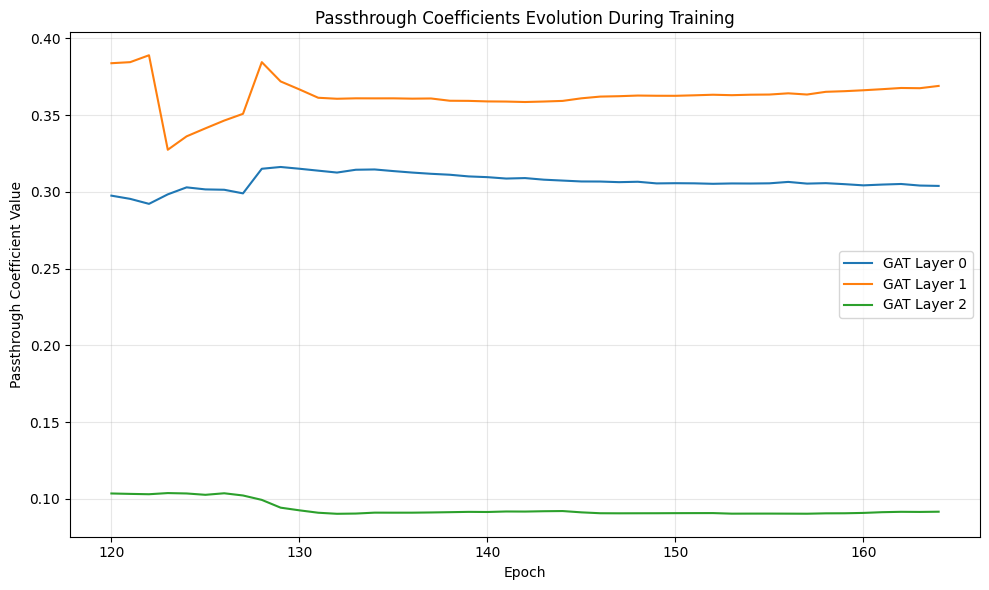

In [10]:
# Plot passthrough_coef values across all model checkpoints
import matplotlib.pyplot as plt
import torch
import glob
import os
import re
import scipy as sp

def extract_passthrough_coeffs(model_path):
    """Extract passthrough_coef values for gat_layers"""
    checkpoint = torch.load(model_path, map_location=torch.device('cpu'))
    model_state = checkpoint["model_state"]
    
    coeffs = []
    for i in range(3):
        param_name = f"gat_layers.{i}.passthrough_coef"
        coeffs.append(model_state[param_name].item())
    
    return coeffs


# Find all checkpoint files
models_dir = f"learning/{model_name}_checkpoints"
checkpoint_files = sorted(glob.glob(os.path.join(models_dir, f"{model_name}_*.pt")))

# Extract epoch numbers and sort files by epoch
pass_coef_data = []
for file_path in checkpoint_files[drop_first_n:]:
    # Extract epoch number from filename
    epoch_match = re.search(r"_(\d+)\.pt$", file_path)
    epoch_num = int(epoch_match.group(1))
    coeffs = extract_passthrough_coeffs(file_path)
    pass_coef_data.append([
        epoch_num,
        *coeffs
    ])
pass_coef_data = np.array(list(sorted(pass_coef_data, key=lambda x: x[0]))).T
pass_coef_data[1:] = sp.special.expit(pass_coef_data[1:])
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
for i in range(3):
    ax.plot(pass_coef_data[0], pass_coef_data[i+1], label=f'GAT Layer {i}')

ax.set_xlabel('Epoch')
ax.set_ylabel('Passthrough Coefficient Value')
ax.set_title('Passthrough Coefficients Evolution During Training')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()